<a href="https://colab.research.google.com/github/davisallan/enel645Team25Assignment3/blob/main/assignment03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 03 - Auto-encoders and The U-net Model

This assignment is composed of two tasks:

1. Design an auto-encoder to denoise a simple image dataset composed of circles;

2. Implement the U-net model for signal denoising;

Each task corresponds to 50% of the final grade of the assignment. Teams with less than 4 people can choose to do just one of the tasks without any penalty. The deliverables for the assignment are:

1. This jupyter-notebook completed with your solution. 
    - Name the notebook as enel645_assignment03_team_(team number).ipynb
2. The weights of your Auto-encoder and U-net models. 
    - Name the weights files as team_(team number)_autoencoder.h5 (task 01) and team_(team number)_unet.h5 (task 02)

Submit the three files (notebook + models' weights) to your dropbox in the course D2L page (two files if your team has less than 4 people)

You are free to add extra cells of text and code to this notebook.

At the end of the notebook, please include a short description of what each team member did in the assignment. Also include the consensus score between 0 and 3 to each team member. This score will be used to adjust the final 
grade of each student. Students developing the project individually do not need this description and score.

You are being assessed based on:

1. Code execution - 20% 
2. Clarity of the code and your model explanation (e.g., easy to follow, has pertinent comments, etc.) - 20%
3. Proper usage of the techniques seen in class - 30% 
4. Accuracy of the models  - 30%

The data for this assignment can be downloaded here:
- [GDrive](https://drive.google.com/file/d/17XmiQ1lNOP28blGmTFv8Zf5cf08unGgV/view?usp=sharing)
- [OneDrive](https://uofc-my.sharepoint.com/:u:/g/personal/roberto_medeirosdeso_ucalgary_ca/EVe0Mh19GUBGp7qXOIaXRtIBYeJgBtBvc5ULFoT1svhudw?e=rVNREx) - Link expires March 8th, 2021. 

## 1. Denoising Auto-encoder

Develop an auto-encoders that receives as input a 96 x 96 noisy image with a circle of a radius R and outputs the corresponding denoised image. Make the dimensionality of your latent space as low as posisble without compromising the results of the denoised images.

- Justify the choice of your latent space dimension;
- The results will be assessed visually;  

# **** NOTE **** After cloning the repo you have to manually upload the 144mb train.npy to `"Data/Assignment03/AUTOENCODER/`

In [ ]:
!git clone https://github.com/davisallan/enel645Team25Assignment3.git

Cloning into 'enel645Team25Assignment3'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 73 (delta 27), reused 11 (delta 0), pack-reused 0
Unpacking objects: 100% (73/73), done.


In [ ]:
# Import additional libraries if you need
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf

In [ ]:
# global variables
seed = 2021

### 1.1 Load data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Adapt the paths to your environment
X_train = np.load("/content/enel645Team25Assignment3/Data/Assignment03/AUTOENCODER/train.npy")[:,:,:,np.newaxis]
X_val = np.load("/content/enel645Team25Assignment3/Data/Assignment03/AUTOENCODER/val.npy")[:,:,:,np.newaxis]
X_test = np.load("/content/enel645Team25Assignment3/Data/Assignment03/AUTOENCODER/test.npy")
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2000, 96, 96, 1)
(500, 96, 96, 1)
(20, 96, 96)


### 1.2. Explore your data 

In [ ]:
# Function for plotting a random selection of 24 images from the dataset passed
def plot_images(dataset_name, dataset, numImages = 24, testSet=False):
  sample_indexes = np.random.choice(np.arange(dataset.shape[0], dtype = int),size = numImages, replace = False)
  plt.figure(figsize=(24,18))
  
  if testSet:
    images = dataset
  else:
    images = dataset[:,:,:,0]

  for i in range(numImages):
      plt.subplot(5, 8, i + 1)
      plt.imshow(images[sample_indexes[i]], cmap = "gray")
      plt.axis("off")
      plt.title("Index = " + str(sample_indexes[i]))
  plt.suptitle("Random sampling of Images from " + dataset_name)
  plt.show()


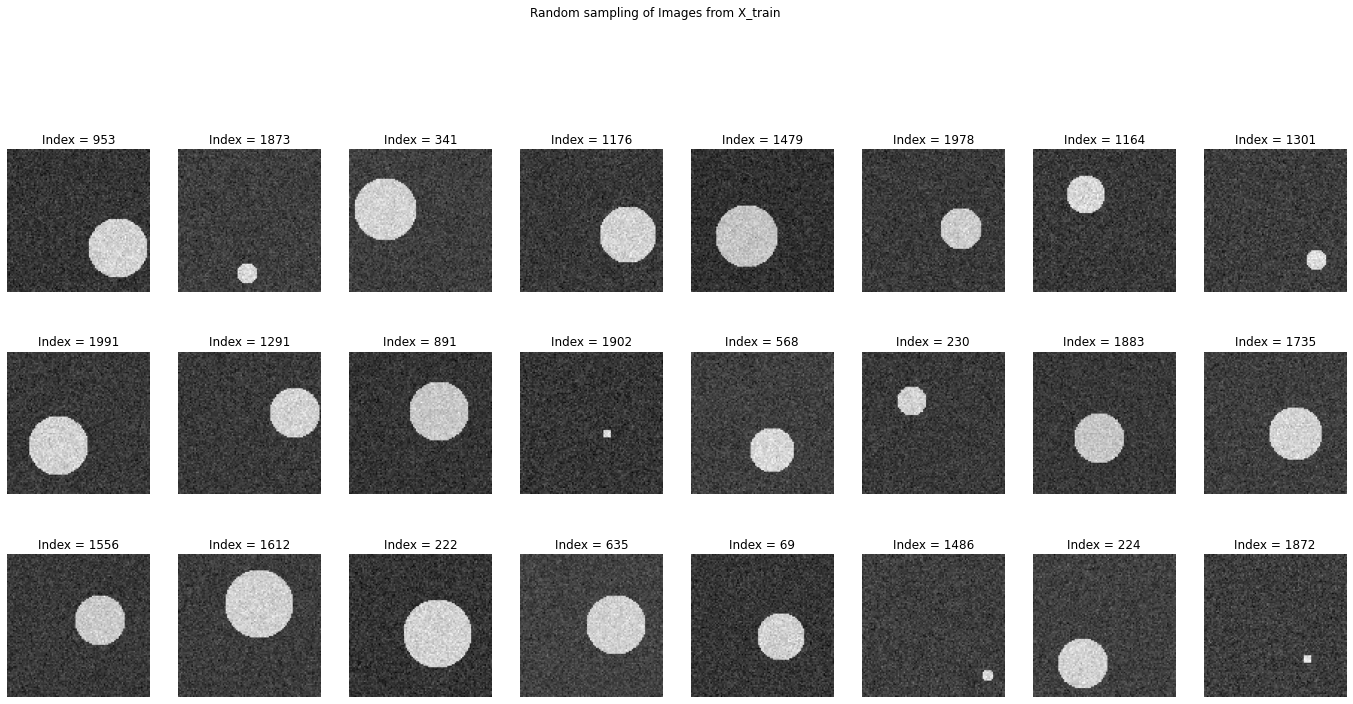

In [ ]:
# plot a random sampling of 24 images from the training dataset
plot_images("X_train", X_train)

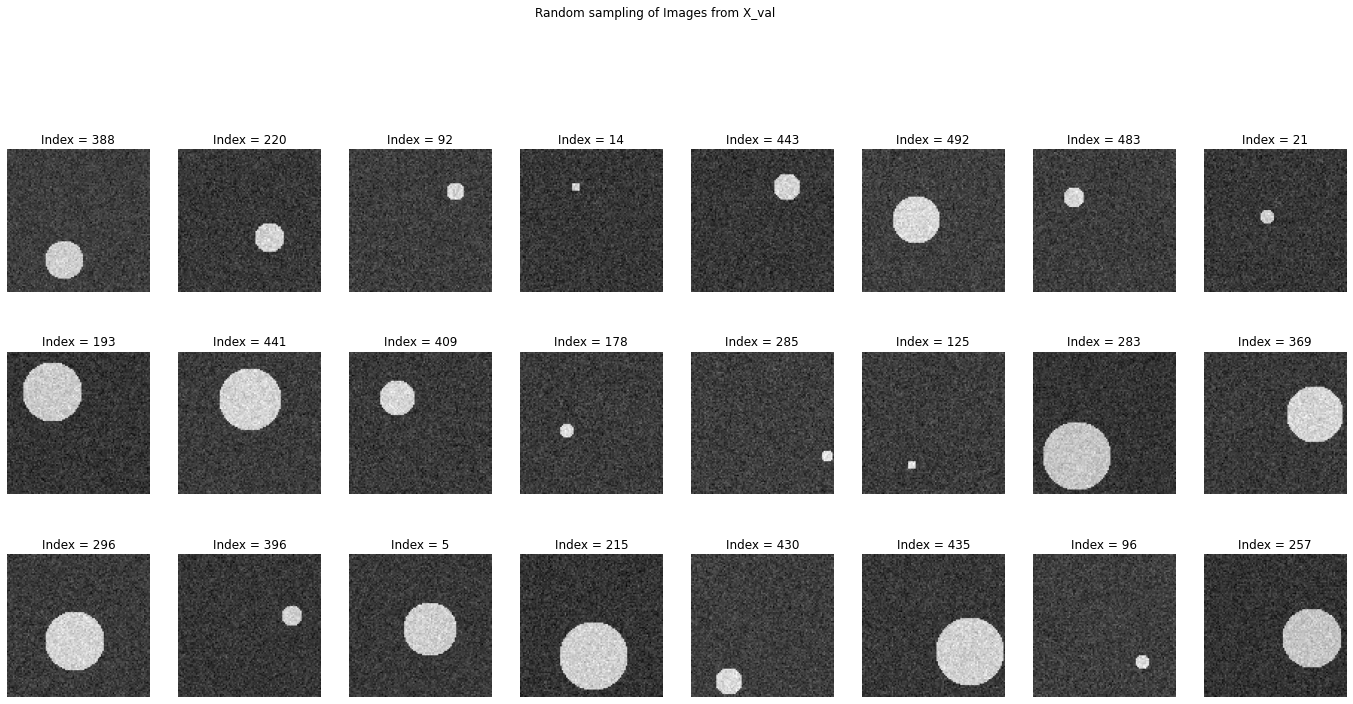

In [ ]:
# plot a random sampling of 24 images from the validation dataset
plot_images("X_val", X_val)

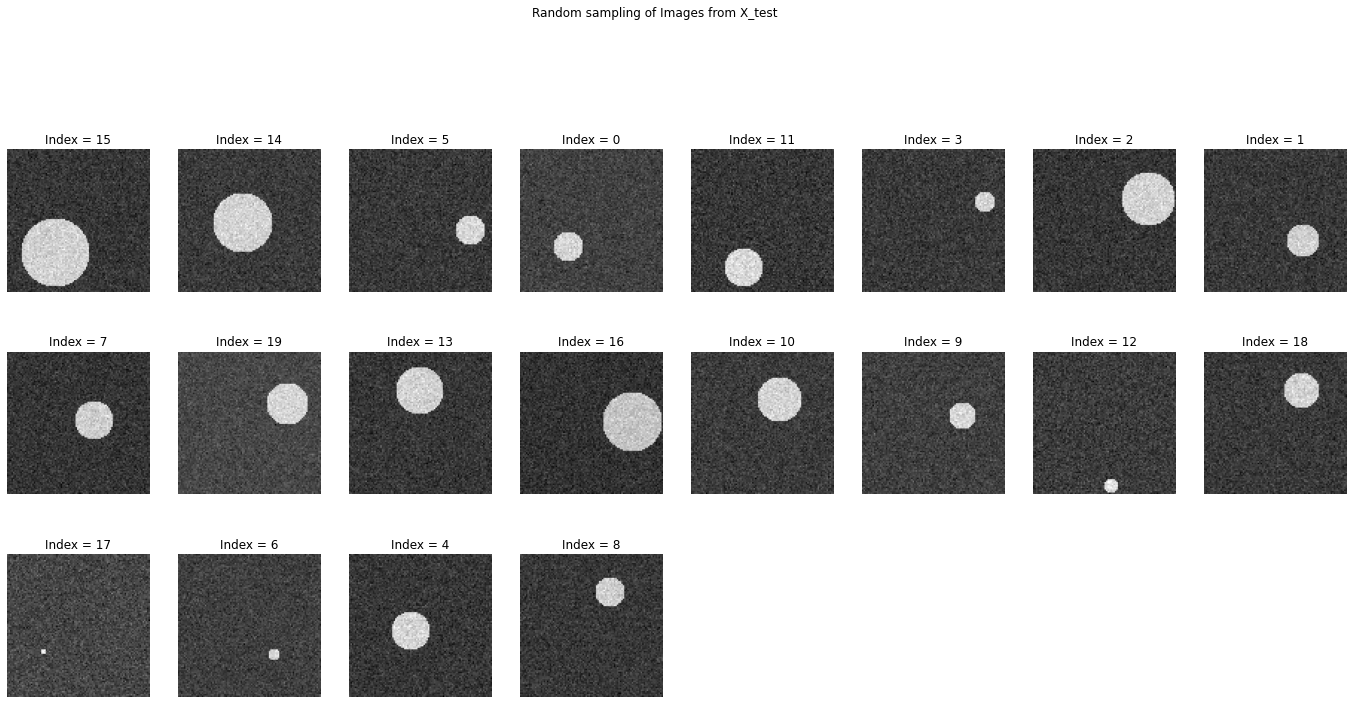

In [ ]:
# plot all 20 images from the test set
plot_images("X_test", X_test, 20, True)

### 1.3. Data scaling and Data augmentation

#### 1.3.1 Data Scaling

In [ ]:
# Data scaling
norm_type = 0 # 0 -> min-max; 1-> standardization

if norm_type == 0:
    X_train = X_train/255
    X_val = X_val/255
    X_test = X_test/255
elif norm_type == 1:
    train_mean, train_std = X_train.mean(),X_train.std() 
    X_train = (X_train - train_mean)/train_std
    X_val = (X_val - train_mean)/train_std
    X_test = (X_test - train_mean)/train_std
else:
    pass

#### 1.3.2 Data Augmentation

In [ ]:
# Definitely just guessing with these parameters for the time being
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=35, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             horizontal_flip=True, 
                             vertical_flip=True)

In [ ]:
X_train_augmented = datagen.flow(X_train, seed = seed)
X_val_augmented = datagen.flow(X_val, seed = seed)

### 1.4. Define your  model, cost function, optimizer, learning rate

In [ ]:
# Define your model here. 
def my_autoencoder(ishape = (96,96,1),ndim = 7200, lr = 1e-4):
  input_img = tf.keras.layers.Input(shape = ishape)
  c1 = tf.keras.layers.Conv2D(32, (4,4), activation= 'relu', strides= (2,2), padding= 'same')(input_img)
  c2 = tf.keras.layers.Conv2D(64, (4,4), activation= 'relu', strides= (2,2), padding= 'same')(c1)
  c3 = tf.keras.layers.Conv2D(128, (4,4), activation= 'relu', strides= (2,2), padding= 'same')(c2)
  c4 = tf.keras.layers.Conv2D(256, (4,4), activation= 'relu', strides= (2,2), padding= 'same')(c3)
  flat = tf.keras.layers.Flatten()(c4)
  d1 = tf.keras.layers.Dense(ndim)(flat)
  encoder = tf.keras.models.Model(inputs = input_img, outputs = d1)
  input_decoder = tf.keras.layers.Input(shape = (ndim))
  d2 = tf.keras.layers.Dense(6*6*256)(input_decoder)
  reshaped_img = tf.keras.layers.Reshape((6,6,256))(d2)
  up1 = tf.keras.layers.UpSampling2D((2,2))(reshaped_img)
  c5 = tf.keras.layers.Conv2D(128, (4,4), activation= 'relu', padding= 'same')(up1)
  up2 = tf.keras.layers.UpSampling2D((2,2))(c5)
  c6 = tf.keras.layers.Conv2D(64, (4,4), activation= 'relu', padding= 'same')(up2)
  up3 = tf.keras.layers.UpSampling2D((2,2))(c6)
  c7 = tf.keras.layers.Conv2D(32, (4,4), activation= 'relu', padding= 'same')(up3)
  up4 = tf.keras.layers.UpSampling2D((2,2))(c7)
  c8 = tf.keras.layers.Conv2D(1, (4,4), activation= 'relu', padding= 'same')(up4)
  decoder = tf.keras.models.Model(inputs= input_decoder, outputs= c8)
  autoencoder = tf.keras.models.Model(inputs = input_img, outputs = decoder(encoder(input_img)))
  autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr), loss = "mae")
  return encoder,decoder,autoencoder

In [ ]:
encoder, decoder, autoencoder = my_autoencoder()

print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 48, 48, 32)        544       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 24, 24, 64)        32832     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 12, 12, 128)       131200    
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 6, 6, 256)         524544    
_________________________________________________________________
flatten_5 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 7200)              663

### 1.5. Define your callbacks (save your model, patience, etc.)

In [ ]:
model_name_autoencoder = "team_25_autoencoder.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_autoencoder, monitor='val_loss',
                                             verbose=0, save_best_only=True,
                                             save_weights_only=True,
                                             mode='min')

def scheduler(epoch, lr):
  if epoch%10 == 0:
    lr = lr/2
  return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)
# define your callbacks
# remember that you need to save the weights of your best model!

### 1.6. Train your model

In [ ]:
# train your model - decide for how many epochs
autoencoder.fit(X_train,X_train, batch_size = 32, epochs = 150, verbose=1, 
                callbacks= [early_stop, monitor, lr_schedule], validation_data=(X_val, X_val))

Epoch 1/150
63/63 [==============================] - 5s 66ms/step - loss: 5.4980e-04 - val_loss: 5.4873e-04
Epoch 2/150
63/63 [==============================] - 4s 63ms/step - loss: 5.4846e-04 - val_loss: 5.4755e-04
Epoch 3/150
63/63 [==============================] - 4s 63ms/step - loss: 5.4479e-04 - val_loss: 5.4698e-04
Epoch 4/150
63/63 [==============================] - 4s 63ms/step - loss: 5.4099e-04 - val_loss: 5.4408e-04
Epoch 5/150
63/63 [==============================] - 4s 63ms/step - loss: 5.3485e-04 - val_loss: 4.2298e-04
Epoch 6/150
63/63 [==============================] - 4s 63ms/step - loss: 3.9624e-04 - val_loss: 3.6470e-04
Epoch 7/150
63/63 [==============================] - 4s 63ms/step - loss: 3.6207e-04 - val_loss: 3.6037e-04
Epoch 8/150
63/63 [==============================] - 4s 63ms/step - loss: 3.5354e-04 - val_loss: 3.4779e-04
Epoch 9/150
63/63 [==============================] - 4s 64ms/step - loss: 3.4504e-04 - val_loss: 3.4379e-04
Epoch 10/150
63/63 [========

### 1.7. Test your model

In [ ]:
autoencoder.load_weights(model_name_autoencoder)
metrics = autoencoder.evaluate(X_test, X_test)
Xpred = autoencoder.predict(X_test)[:,:,:,0]

# Remember to "unscale your data".
Xpred = Xpred*255
X_test = X_test*255

#Showing results
plt.figure(figsize = (24,18), dpi = 300)
for (ii) in range(20):
    plt.subplot(5,8,ii*2+1)
    plt.imshow(X_test[ii], cmap = "gray")
    plt.axis("off")
    plt.title("Noisy")
    plt.subplot(5,8,ii*2 + 2)
    plt.imshow(Xpred[ii], cmap = "gray")
    plt.axis("off")
    plt.title("Denoised")
plt.show()

In [ ]:
# train your model - decide for how many epochs
autoencoder.fit(X_train,X_train, batch_size = 32, epochs = 115, verbose=1, 
                callbacks= [early_stop, monitor, lr_schedule], validation_data=(X_val, X_val))

Epoch 1/115
63/63 [==============================] - 4s 53ms/step - loss: 5.5716e-04 - val_loss: 5.4785e-04
Epoch 2/115
63/63 [==============================] - 3s 50ms/step - loss: 5.3900e-04 - val_loss: 5.4658e-04
Epoch 3/115
63/63 [==============================] - 3s 50ms/step - loss: 5.4460e-04 - val_loss: 5.3908e-04
Epoch 4/115
63/63 [==============================] - 3s 50ms/step - loss: 5.0998e-04 - val_loss: 4.0941e-04
Epoch 5/115
63/63 [==============================] - 3s 50ms/step - loss: 3.9132e-04 - val_loss: 3.7220e-04
Epoch 6/115
63/63 [==============================] - 3s 50ms/step - loss: 3.6562e-04 - val_loss: 3.5761e-04
Epoch 7/115
63/63 [==============================] - 3s 50ms/step - loss: 3.5292e-04 - val_loss: 3.4958e-04
Epoch 8/115
63/63 [==============================] - 3s 51ms/step - loss: 3.4730e-04 - val_loss: 3.4535e-04
Epoch 9/115
63/63 [==============================] - 3s 51ms/step - loss: 3.4168e-04 - val_loss: 3.3879e-04
Epoch 10/115
63/63 [========

1/1 [==============================] - 0s 214ms/step - loss: 3.2338e-04


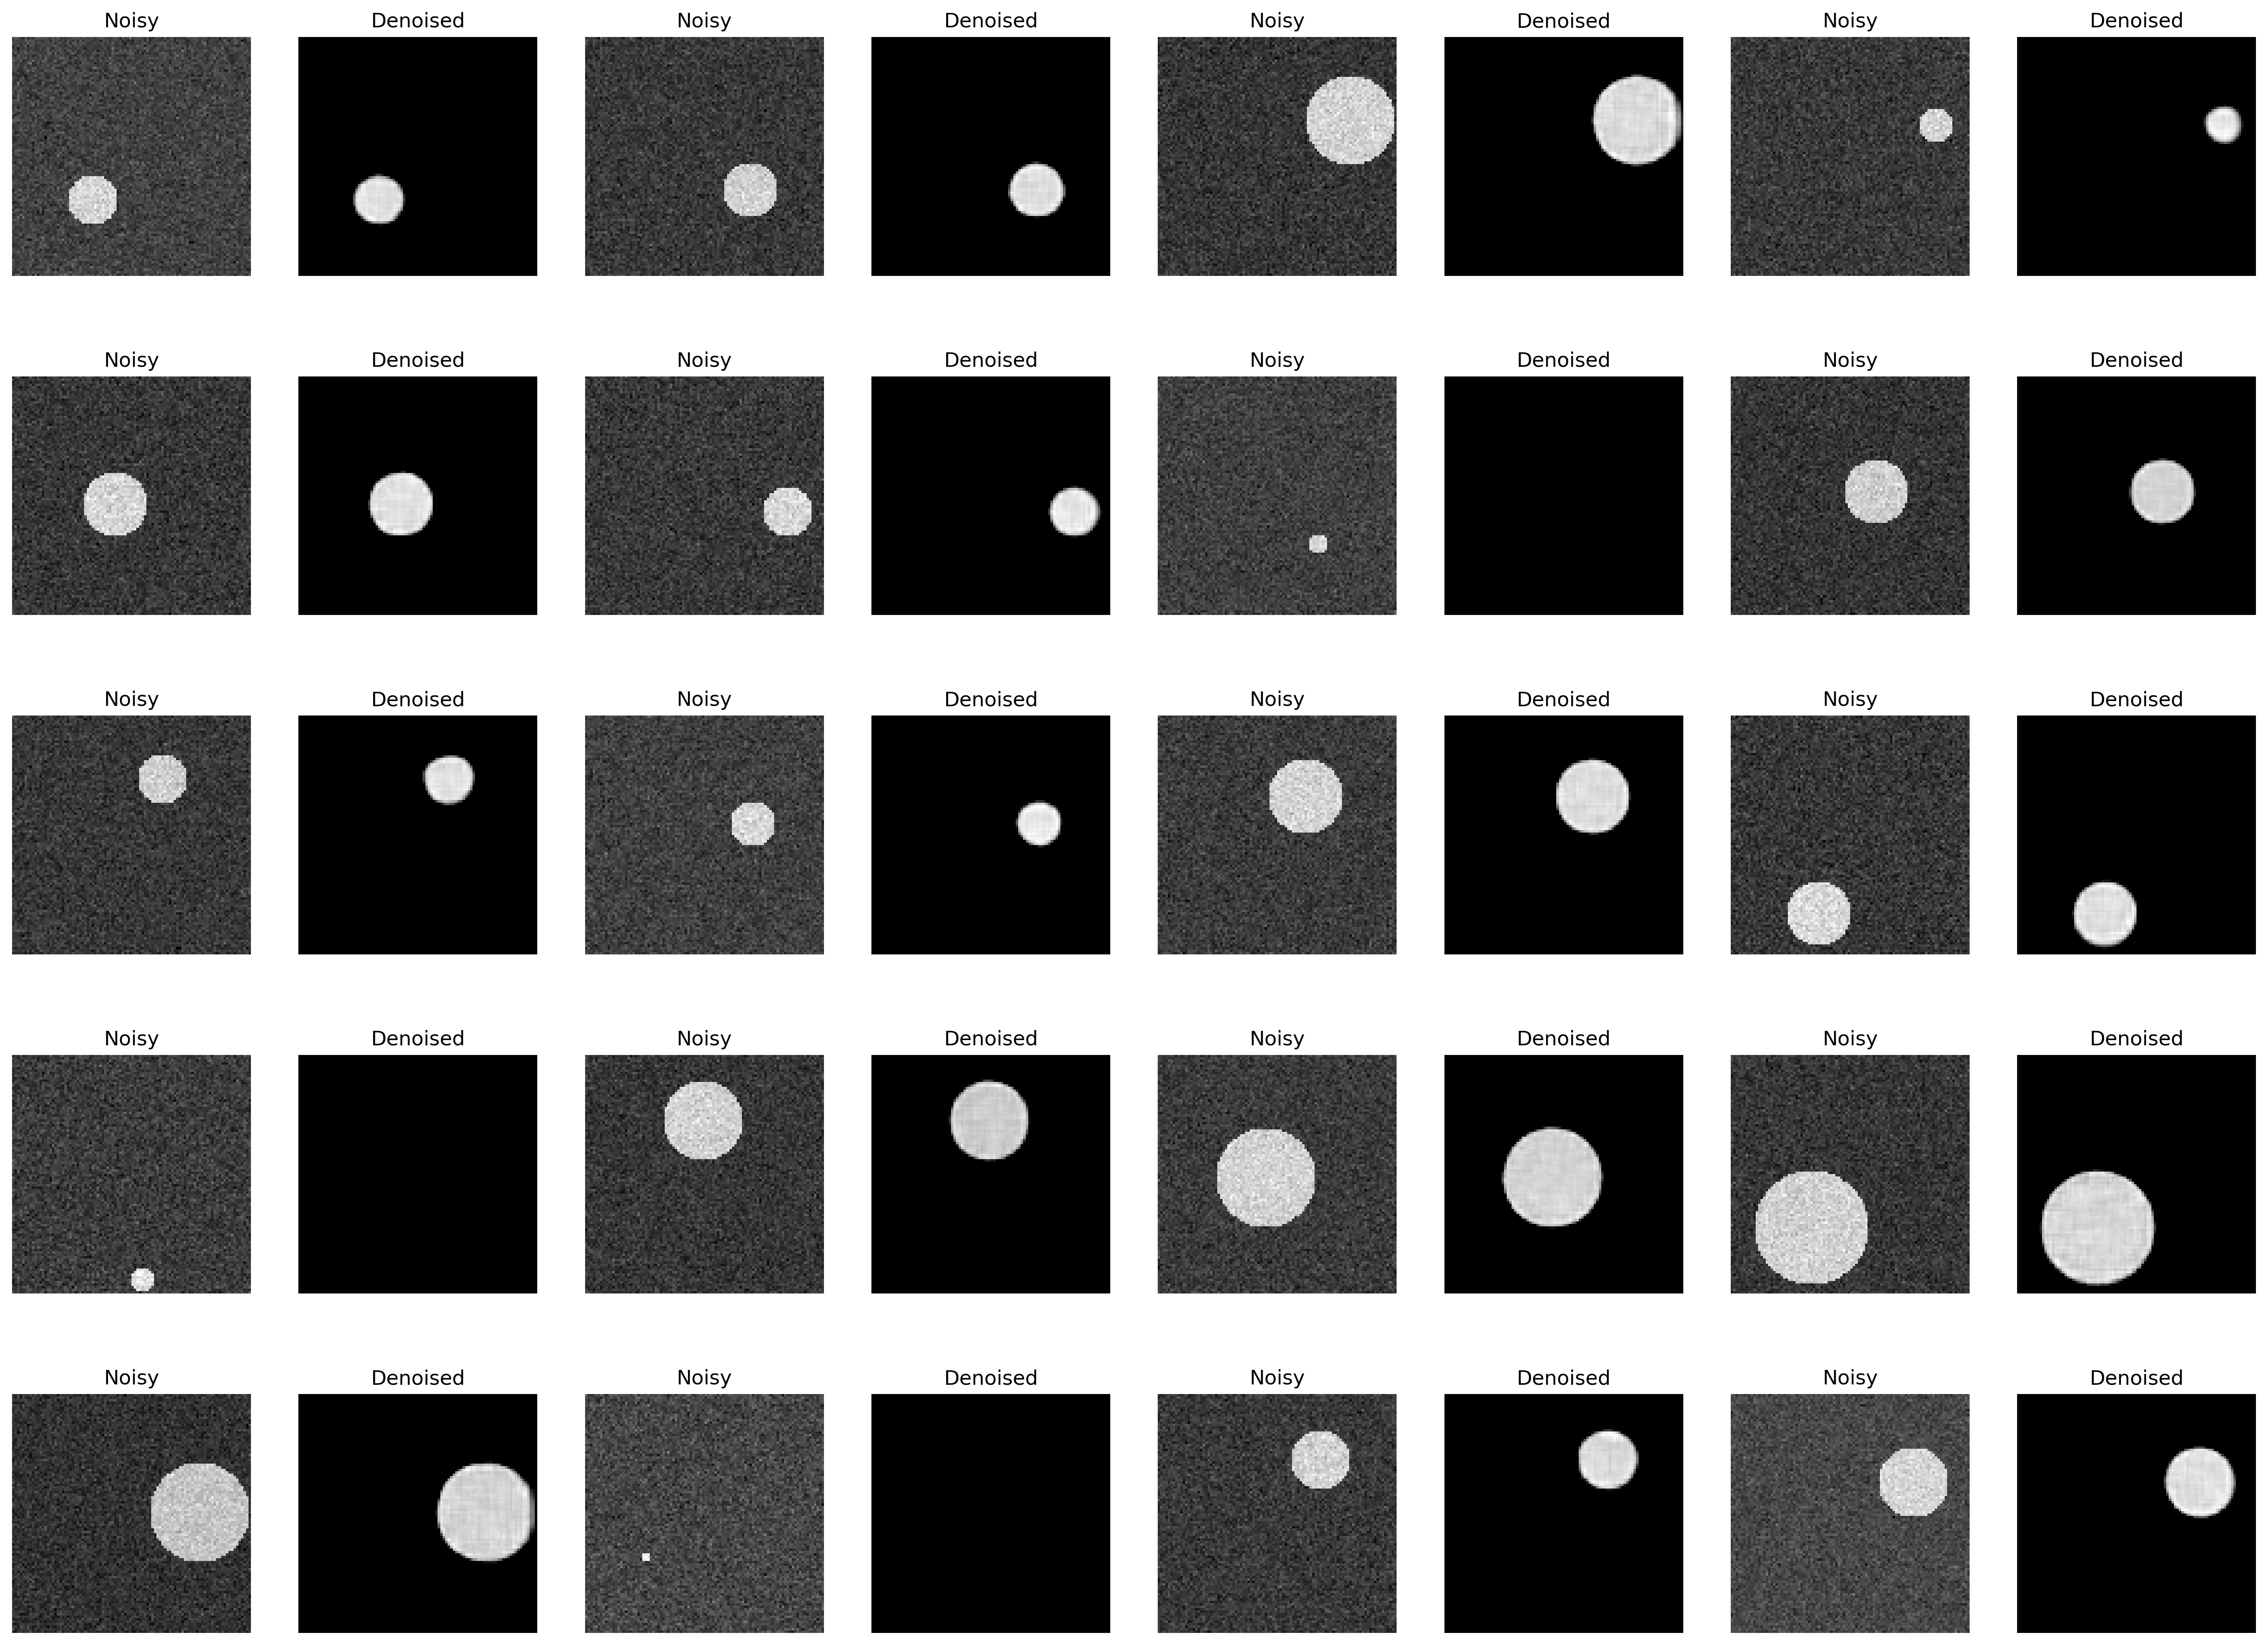

In [ ]:
autoencoder.load_weights(model_name_autoencoder)
metrics = autoencoder.evaluate(X_test, X_test)
Xpred = autoencoder.predict(X_test)[:,:,:,0]

# Remember to "unscale your data".
Xpred = Xpred*255
X_test = X_test*255

#Showing results
plt.figure(figsize = (24,18), dpi = 300)
for (ii) in range(20):
    plt.subplot(5,8,ii*2+1)
    plt.imshow(X_test[ii], cmap = "gray")
    plt.axis("off")
    plt.title("Noisy")
    plt.subplot(5,8,ii*2 + 2)
    plt.imshow(Xpred[ii], cmap = "gray")
    plt.axis("off")
    plt.title("Denoised")
plt.show()

In [ ]:
# train your model - decide for how many epochs
autoencoder.fit(X_train,X_train, batch_size = 32, epochs = 115, verbose=1, 
                callbacks= [early_stop, monitor, lr_schedule], validation_data=(X_val, X_val))

Epoch 1/115
63/63 [==============================] - 4s 49ms/step - loss: 5.5250e-04 - val_loss: 5.4933e-04
Epoch 2/115
63/63 [==============================] - 2s 39ms/step - loss: 5.5495e-04 - val_loss: 5.4799e-04
Epoch 3/115
63/63 [==============================] - 2s 39ms/step - loss: 5.4604e-04 - val_loss: 5.4646e-04
Epoch 4/115
63/63 [==============================] - 2s 39ms/step - loss: 5.4927e-04 - val_loss: 5.3925e-04
Epoch 5/115
63/63 [==============================] - 2s 39ms/step - loss: 5.1500e-04 - val_loss: 3.9736e-04
Epoch 6/115
63/63 [==============================] - 2s 39ms/step - loss: 3.8263e-04 - val_loss: 3.6439e-04
Epoch 7/115
63/63 [==============================] - 2s 39ms/step - loss: 3.5965e-04 - val_loss: 3.5307e-04
Epoch 8/115
63/63 [==============================] - 2s 39ms/step - loss: 3.5217e-04 - val_loss: 3.4596e-04
Epoch 9/115
63/63 [==============================] - 2s 39ms/step - loss: 3.4421e-04 - val_loss: 3.4317e-04
Epoch 10/115
63/63 [========

1/1 [==============================] - 0s 181ms/step - loss: 3.2320e-04


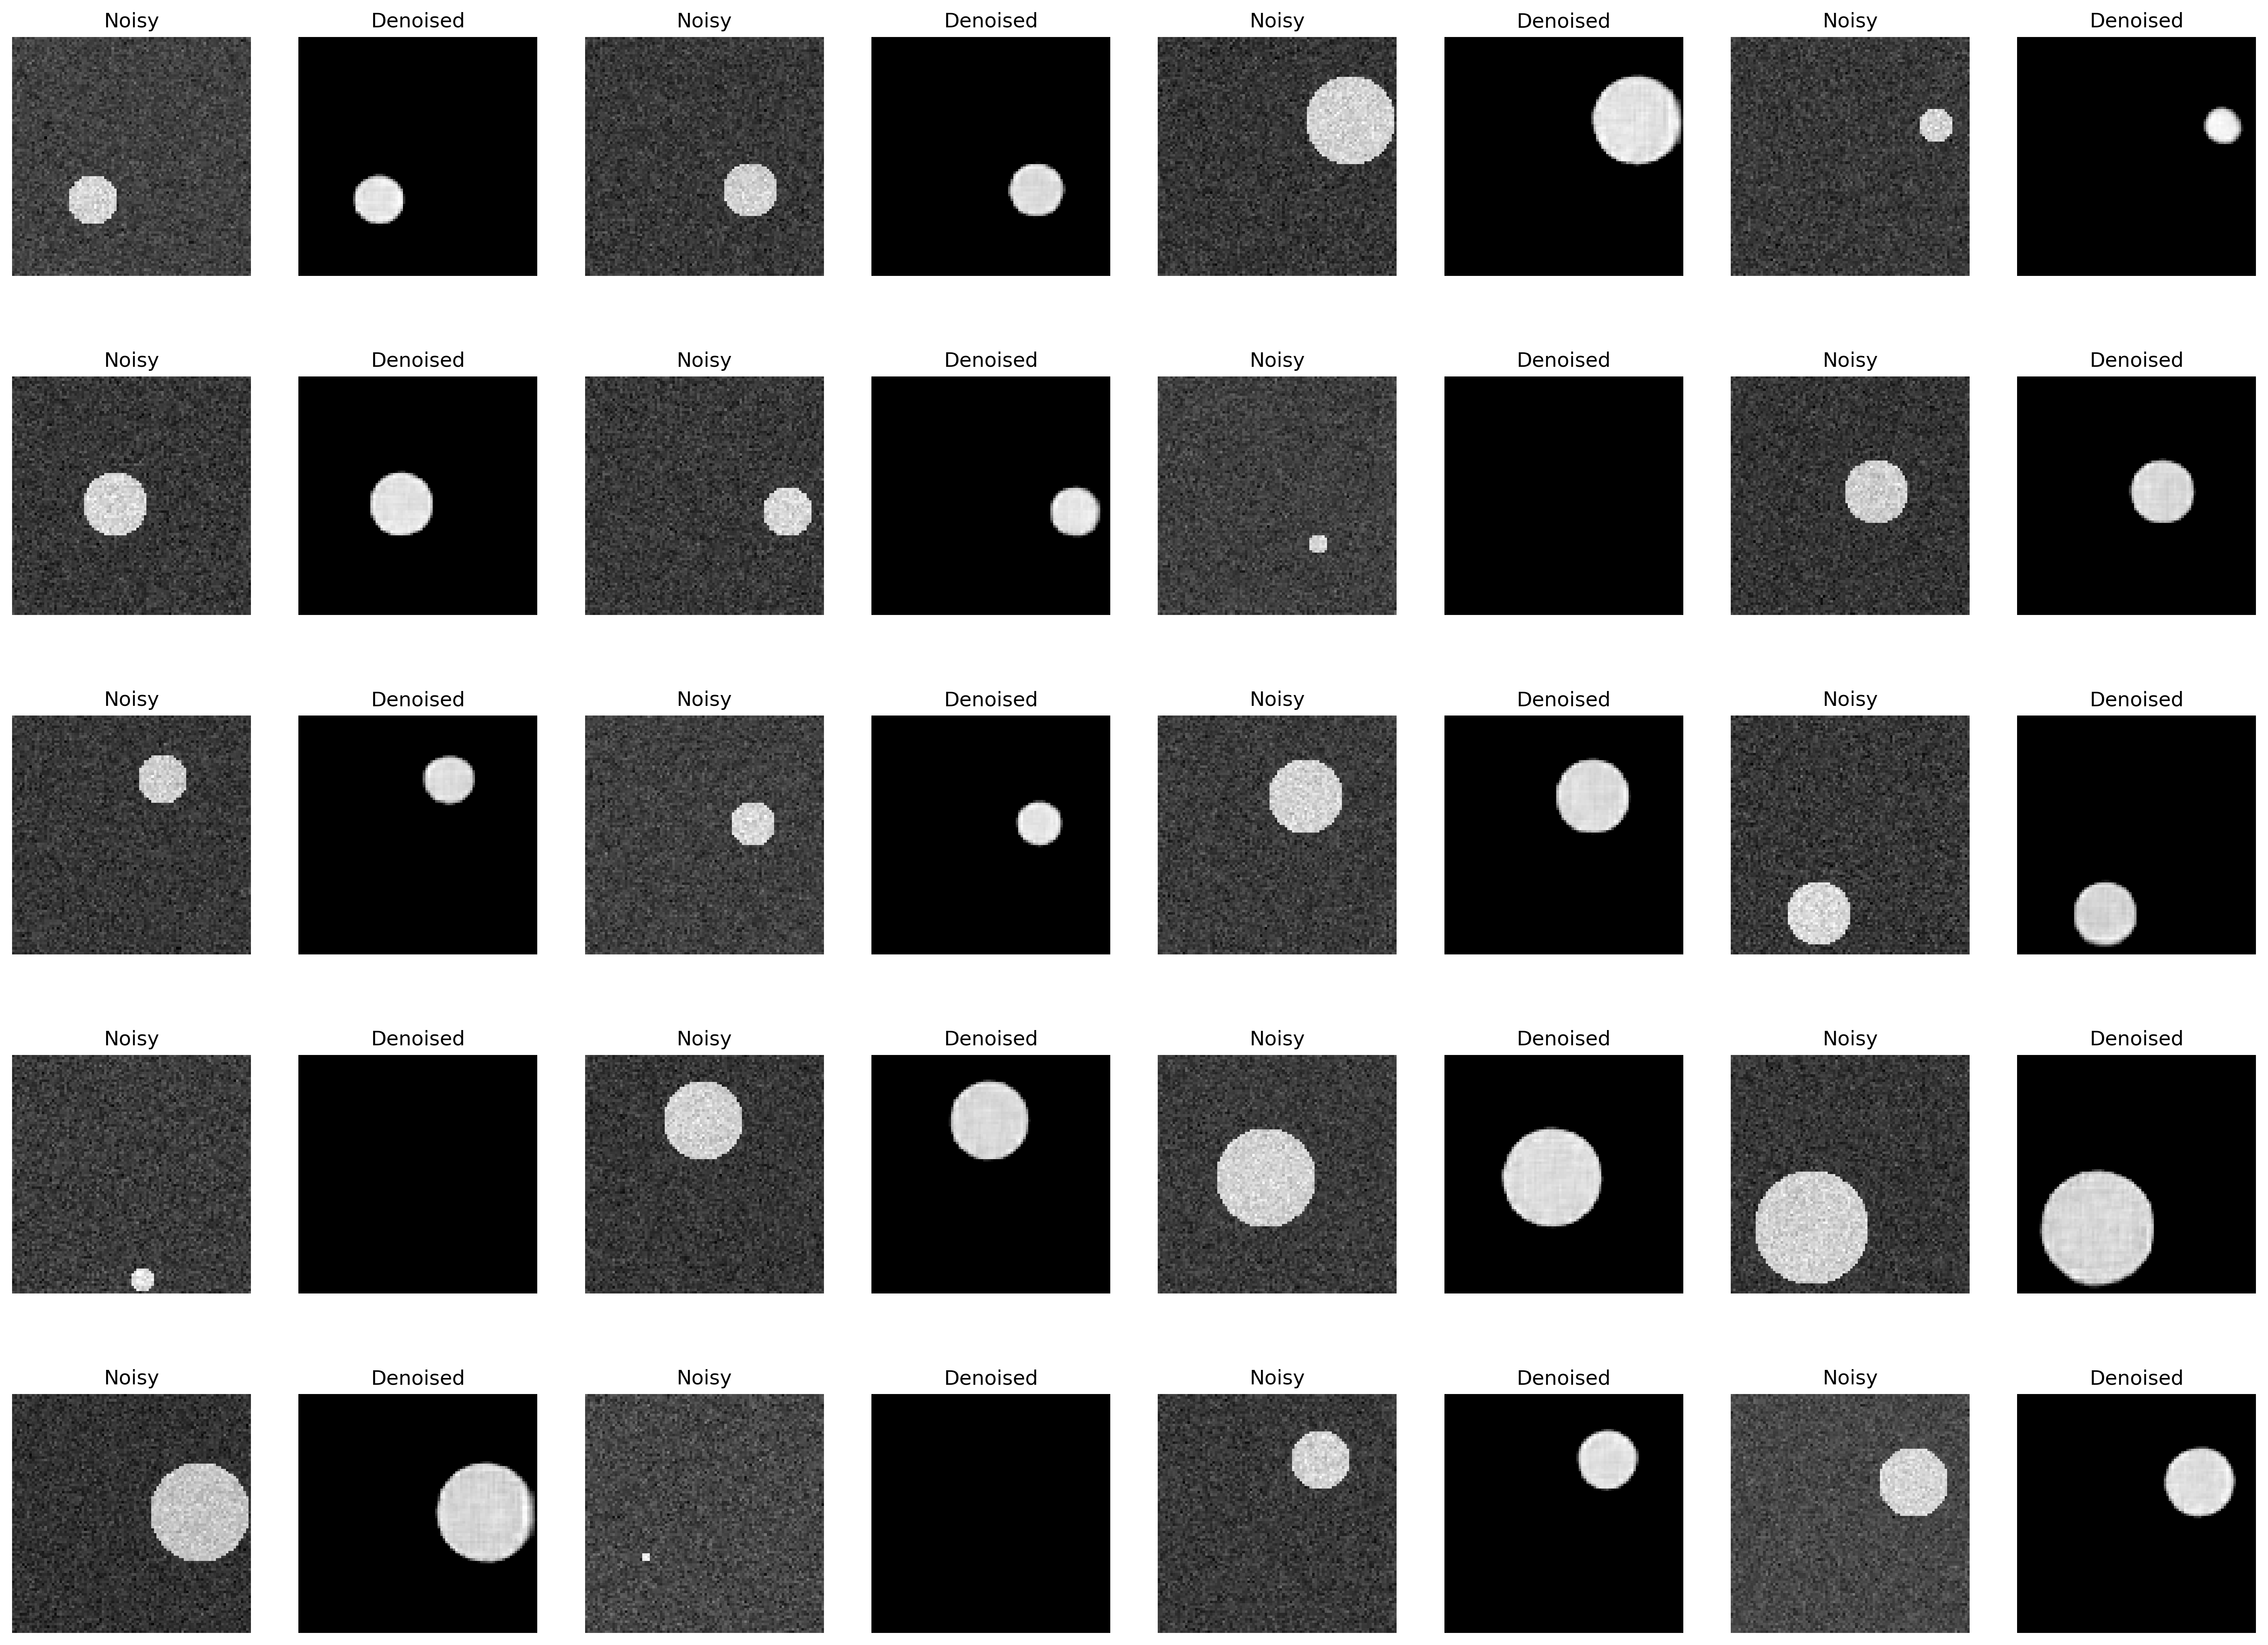

In [ ]:
autoencoder.load_weights(model_name_autoencoder)
metrics = autoencoder.evaluate(X_test, X_test)
Xpred = autoencoder.predict(X_test)[:,:,:,0]

# Remember to "unscale your data".
Xpred = Xpred*255
X_test = X_test*255

#Showing results
plt.figure(figsize = (24,18), dpi = 300)
for (ii) in range(20):
    plt.subplot(5,8,ii*2+1)
    plt.imshow(X_test[ii], cmap = "gray")
    plt.axis("off")
    plt.title("Noisy")
    plt.subplot(5,8,ii*2 + 2)
    plt.imshow(Xpred[ii], cmap = "gray")
    plt.axis("off")
    plt.title("Denoised")
plt.show()

## 2. Denoising U-net

Develop an U-net model that receives as input 20 1-dimensional noisy measurements of the same signal and outputs the denoised signal.

The mean squared error (MSE) of your U-net model should be lower than the MSE of just averaging the noisy measurements. 

- The results will be assessed using mean squared error. 

### 2.1 Load data  and split into train, validation, test

In [ ]:
data = np.load("/content/enel645Team25Assignment3/Data/Assignment03/UNET/noisy_transients.npy")
target = np.load("/content/enel645Team25Assignment3/Data/Assignment03/UNET/reference.npy")
indexes = np.arange(data.shape[0], dtype = int)
np.random.shuffle(indexes)
data = data[indexes]
target = target[indexes]
X_train2 = data[:int(data.shape[0]*0.8)]
Y_train2 = target[:int(data.shape[0]*0.8)]

X_val2 = data[int(data.shape[0]*0.8):int(data.shape[0]*0.9)]
Y_val2 = target[int(data.shape[0]*0.8):int(data.shape[0]*0.9)]

X_test2 = data[int(data.shape[0]*0.9):]
Y_test2 = target[int(data.shape[0]*0.9):]

print(X_train2.shape)
print(Y_train2.shape)
print(X_val2.shape)
print(Y_val2.shape)
print(X_test2.shape)
print(Y_test2.shape)

(216, 256, 20)
(216, 256)
(27, 256, 20)
(27, 256)
(27, 256, 20)
(27, 256)


### 2.2. Explore your data

In [ ]:
# Use this space to explore you datasets
# Create additional cells as you see fit

In [ ]:
# define a plotting function to visualize signals pairs from each set
def plot_signal_pairs(X_data_set, Y_data_set):
  sample_indexes = np.random.choice(np.arange(X_data_set.shape[0], dtype=int), size = 9, replace=False)
  plt.figure(figsize=(18,10))
  for (i,j) in enumerate(sample_indexes):
    plt.subplot(3,3,i+1)
    plt.plot(X_data_set[j,:,0], label="Noisy")
    plt.plot(Y_data_set[j], label="Target")
    plt.legend()
  plt.show()

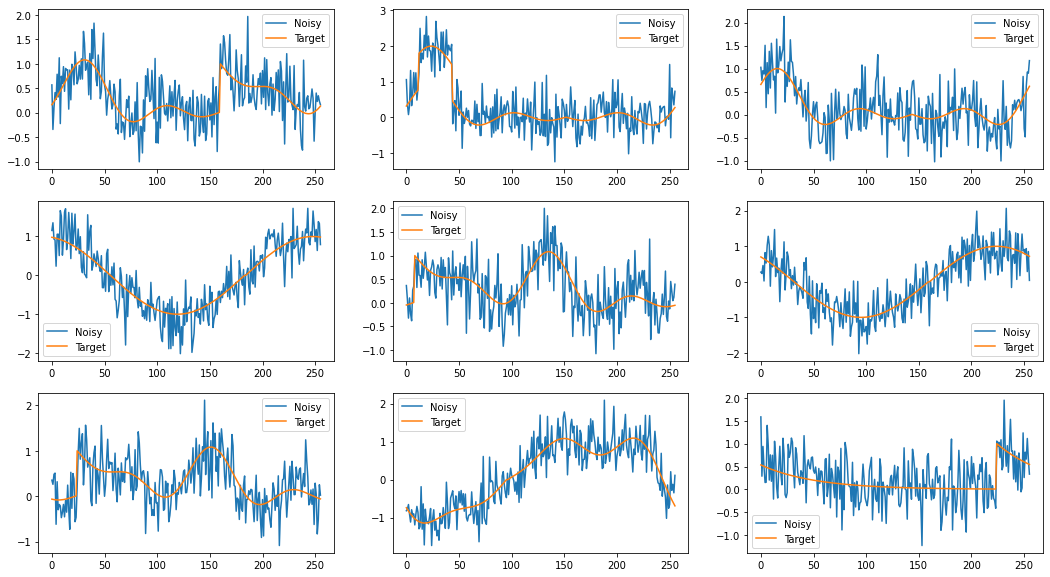

In [ ]:
# plot 9 random sets of noisy, clean signals from the training set
plot_signal_pairs(X_train2,Y_train2)

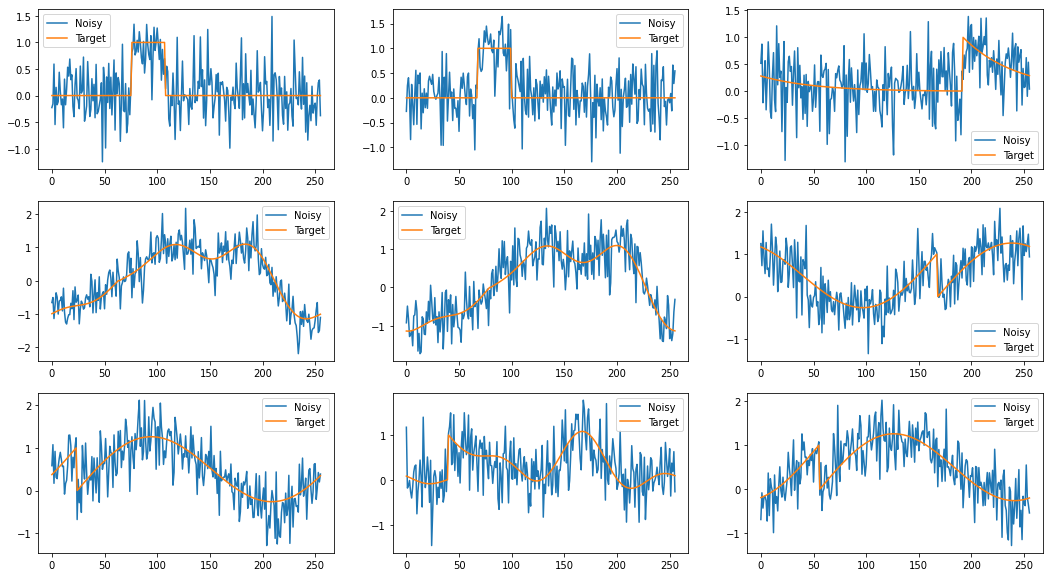

In [ ]:
# plot 9 random sets of noisy, clean signals from the validation set
plot_signal_pairs(X_val2,Y_val2)

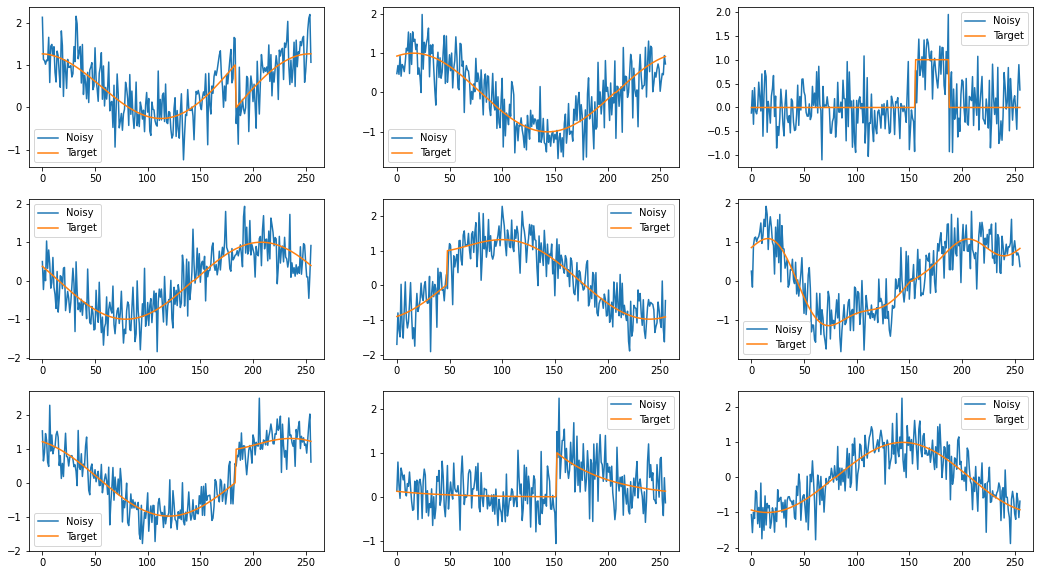

In [ ]:
# plot 9 random sets of noisy, clean signals from the test set
plot_signal_pairs(X_test2,Y_test2)

In [ ]:
# Get some descriptive statistics of of training and validation sets before any scaling/standardization

print("Descriptive statistics for training feature matrix and target vector before scaling/standardization")
print(X_train2.min(), X_train2.max(), X_train2.mean(), X_train2.std())
print(Y_train2.min(), Y_train2.max(), Y_train2.mean(), Y_train2.std(), "\n")

print("Descriptive statistics for validation feature matrix and target vector before scaling/standardization")
print(X_val2.min(), X_val2.max(), X_val2.mean(), X_val2.std())
print(Y_val2.min(), Y_val2.max(), Y_val2.mean(), Y_val2.std(), "\n")

print("Descriptive statistics for test feature matrix and target vector before scaling/standardization")
print(X_test2.min(), X_test2.max(), X_test2.mean(), X_test2.std())
print(Y_test2.min(), Y_test2.max(), Y_test2.mean(), Y_test2.std())

Descriptive statistics for training feature matrix and target vector before scaling/standardization
-2.9169581831740183 3.7456143553633217 0.202456629699003 0.7262156728652335
-1.1411321715982128 1.9995952979705165 0.20191041289791556 0.5866924146112275 

Descriptive statistics for validation feature matrix and target vector before scaling/standardization
-2.5712982990589186 3.0822964096468697 0.22400982505008396 0.7154677793303559
-1.1411321715982128 1.3191175931546932 0.22450486205597608 0.5728407315683646 

Descriptive statistics for test feature matrix and target vector before scaling/standardization
-2.5452306805674807 3.7339438767046707 0.18493221648617195 0.7385037329111078
-1.1411321715982128 1.9995952979705165 0.1854139411978516 0.6017293006980611


### 2.3. Data scaling and Data augmentation

In [ ]:
# Experiment with different data scaling methods

# Use data augmentation if you think it makes sense...

In [ ]:
# Implement different types of data scaling

norm_type = 1 # 0 for min-max scaling, 1 for standardization, any other integer for using the data as-is

# case for data normalization
if norm_type == 0: # relu activation will be able to be used here, however this doesn't yield a good signal pair plot
  # scale the feature matrices
  X_train2_min, X_train2_max = X_train2.min(), X_train2.max()
  X_train2_scaled = (X_train2 - X_train2_min)/(X_train2_max - X_train2_min)
  X_val2_scaled = (X_val2 - X_train2_min)/(X_train2_max - X_train2_min)
  X_test2_scaled = (X_test2 - X_train2_min)/(X_train2_max - X_train2_min)

  # scale the target vectors
  Y_train2_min, Y_train2_max = Y_train2.min(), Y_train2.max()
  Y_train2_scaled = (Y_train2 - Y_train2_min)/(Y_train2_max - Y_train2_min)
  Y_val2_scaled = (Y_val2 - Y_train2_min)/(Y_train2_max - Y_train2_min)
  Y_test2_scaled = (Y_test2 - Y_train2_min)/(Y_train2_max - Y_train2_min)

# case for data standardization
elif norm_type == 1: # relu activation won't be able to be used here, maybe try TanH?
  # scale the feature matrices.
  X_train2_mean, X_train2_std = X_train2.mean(), X_train2.std()
  X_train2_scaled = (X_train2 - X_train2_mean)/X_train2_std
  X_val2_scaled = (X_val2 - X_train2_mean)/X_train2_std
  X_test2_scaled = (X_test2 - X_train2_mean)/X_train2_std

  # scale the target vectors
  Y_train2_mean, Y_train2_std = Y_train2.mean(), Y_train2.std()
  Y_train2_scaled = (Y_train2 - Y_train2_mean)/Y_train2_std
  Y_val2_scaled = (Y_val2 - Y_train2_mean)/Y_train2_std
  Y_test2_scaled = (Y_test2 - Y_train2_mean)/Y_train2_std
  
# case for using the data as-is, no normalization or standardization
else:
  pass

In [ ]:
# Get some descriptive statistics of of training, validation, and test sets after any scaling/standardization
print("Descriptive statistics for training feature matrix and target vector after scaling/standardization")
print(X_train2_scaled.min(), X_train2_scaled.max(), X_train2_scaled.mean(), X_train2_scaled.std())
print(Y_train2_scaled.min(), Y_train2_scaled.max(), Y_train2_scaled.mean(), Y_train2_scaled.std(), "\n")

print("Descriptive statistics for validation feature matrix and target vector after scaling/standardization")
print(X_val2_scaled.min(), X_val2_scaled.max(), X_val2_scaled.mean(), X_val2_scaled.std())
print(Y_val2_scaled.min(), Y_val2_scaled.max(), Y_val2_scaled.mean(), Y_val2_scaled.std(), "\n")

print("Descriptive statistics for test feature matrix and target vector after scaling/standardization")
print(X_test2_scaled.min(), X_test2_scaled.max(), X_test2_scaled.mean(), X_test2_scaled.std())
print(Y_test2_scaled.min(), Y_test2_scaled.max(), Y_test2_scaled.mean(), Y_test2_scaled.std())

Descriptive statistics for training feature matrix and target vector after scaling/standardization
-4.295438572078163 4.878933157260344 7.709882115452476e-18 0.9999999999999999
-2.2891766640379996 3.0641011206252586 -1.3363795666784291e-17 1.0 

Descriptive statistics for validation feature matrix and target vector after scaling/standardization
-3.8194644268888664 3.965543415753696 0.029678780225224764 0.9852001355293359
-2.2891766640379996 1.9042468462748006 0.038511575393441494 0.9763902128306163 

Descriptive statistics for test feature matrix and target vector after scaling/standardization
-3.7835692796682205 4.862862891780385 -0.024131141570781185 1.0169206759162779
-2.2891766640379996 3.0641011206252586 -0.028117751805254467 1.0256299309695318


In [ ]:
# define a plotting function to visualize signals pairs from each set
def plot_signal_pairs_2D(X_data_set, Y_data_set):
  sample_indexes = np.random.choice(np.arange(X_data_set.shape[0], dtype=int), size = 9, replace=False)
  plt.figure(figsize=(18,10))
  for (i,j) in enumerate(sample_indexes):
    plt.subplot(3,3,i+1)
    plt.plot(X_data_set[j,:,0], label="Noisy")
    plt.plot(Y_data_set[j], label="Target")
    plt.legend()
  plt.show()


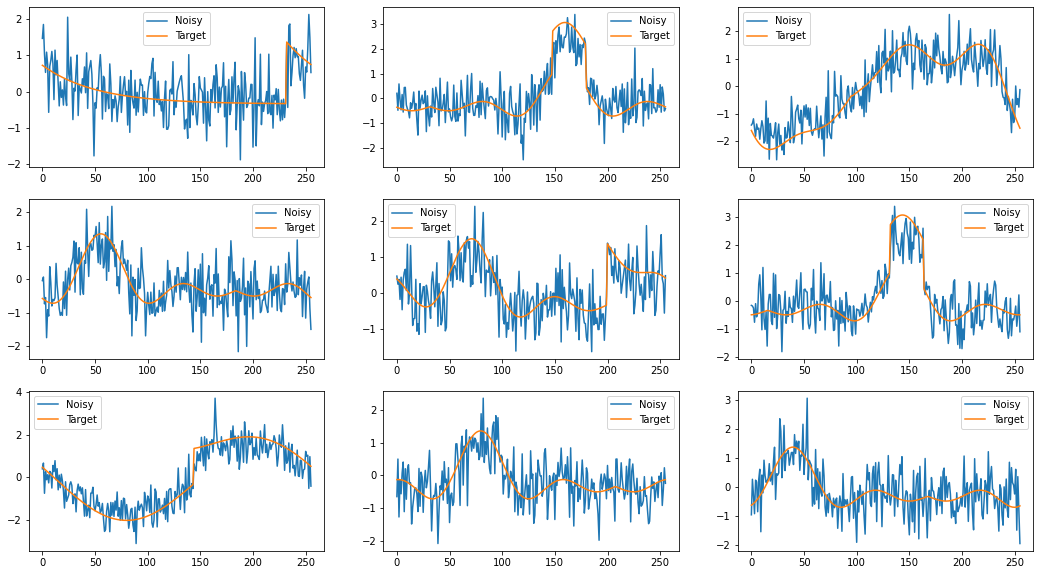

In [ ]:
# Show what some signal pairs look like after scaling/standardization in the training set
plot_signal_pairs_2D(X_train2_scaled,Y_train2_scaled)

In [ ]:
#this will take the average of the 20 measured signals, so as to compare a single signal for the input, to a single signal on the output of the model
X_train2_scaled_avg = np.mean(X_train2_scaled, axis = -1)
X_val2_scaled_avg = np.mean(X_val2_scaled, axis = -1)
X_test2_scaled_avg = np.mean(X_test2_scaled, axis = -1)

### 2.4. Define your  model, cost function, optimizer, learning rate

In [ ]:
# Define your model here. 
# using a kernel size of 3 and a 10% drop out rate for dropout layers
def my_unet(lr = 1e-3, learning_decay = 1e-6, drop_out = 0.1, kshape = 3):

  # define the input shape (1 channel since we took the average of the 20 signals)
  input_shape = (256, 1)
  dropout = drop_out
  pool_size = 2
  size = 2

  input = tf.keras.layers.Input(input_shape)

  #using 1D convolutional and maxpooling layers since input is 1D, relu is the chosen activation function
  conv1 = tf.keras.layers.Conv1D(48, kshape, activation='relu', padding='same')(input)
  conv1 = tf.keras.layers.Conv1D(48, kshape, activation='relu', padding='same')(conv1)
  pool1 = tf.keras.layers.MaxPooling1D(pool_size=pool_size)(conv1)

  conv2 = tf.keras.layers.Conv1D(96, kshape, activation='relu', padding='same')(pool1)
  conv2 = tf.keras.layers.Conv1D(96, kshape, activation='relu', padding='same')(conv2)
  pool2 = tf.keras.layers.MaxPooling1D(pool_size=pool_size)(conv2)

  conv3 = tf.keras.layers.Conv1D(192, kshape, activation='relu', padding='same')(pool2)
  conv3 = tf.keras.layers.Conv1D(192, kshape, activation='relu', padding='same')(conv3)
  pool3 = tf.keras.layers.MaxPooling1D(pool_size=pool_size)(conv3)

  conv4 = tf.keras.layers.Conv1D(384, kshape, activation='relu', padding='same')(pool3)
  conv4 = tf.keras.layers.Conv1D(384, kshape, activation='relu', padding='same')(conv4)
  pool4 = tf.keras.layers.MaxPooling1D(pool_size=pool_size)(conv4)
  pool4 = tf.keras.layers.Dropout(dropout)(pool4)

  conv5 = tf.keras.layers.Conv1D(768, kshape, activation='relu', padding='same')(pool4)
  conv5 = tf.keras.layers.Conv1D(768, kshape, activation='relu', padding='same')(conv5)

  # concatenate layers are defining the skip layers in this model
  up6 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling1D(size=size)(conv5), conv4], axis=-1)
  up6 = tf.keras.layers.Dropout(dropout)(up6)
  conv6 = tf.keras.layers.Conv1D(384, kshape, activation='relu', padding='same')(up6)
  conv6 = tf.keras.layers.Conv1D(384, kshape, activation='relu', padding='same')(conv6)

  up7 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling1D(size=size)(conv6), conv3], axis=-1)
  up7 = tf.keras.layers.Dropout(dropout)(up7)
  conv7 = tf.keras.layers.Conv1D(192, kshape, activation='relu', padding='same')(up7)
  conv7 = tf.keras.layers.Conv1D(192, kshape, activation='relu', padding='same')(conv7)

  up8 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling1D(size=size)(conv7), conv2], axis=-1)
  up8 = tf.keras.layers.Dropout(dropout)(up8)
  conv8 = tf.keras.layers.Conv1D(96, kshape, activation='relu', padding='same')(up8)
  conv8 = tf.keras.layers.Conv1D(96, kshape, activation='relu', padding='same')(conv8)

  up9 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling1D(size=size)(conv8), conv1], axis=-1)
  up9 = tf.keras.layers.Dropout(dropout)(up9)
  conv9 = tf.keras.layers.Conv1D(48, kshape, activation='relu', padding='same')(up9)
  conv9 = tf.keras.layers.Conv1D(48, kshape,  activation='relu', padding='same')(conv9)

  # we want to also ouput a single channel for the output layer in this model to match the input size
  conv10 = tf.keras.layers.Conv1D(1, 1, activation='linear')(up9)
  out = tf.keras.layers.Add()([conv10, input])
  model = tf.keras.models.Model(inputs=input, outputs=out)
  opt = tf.keras.optimizers.Adam(learning_rate=lr, decay=learning_decay)
  model.compile(optimizer = opt, loss = 'mse')

  return model

In [ ]:
# this will show the parameters our model can be expected to generate
model = my_unet()
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 48)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 256, 48)      6960        conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 128, 48)      0           conv1d_1[0][0]                   
______________________________________________________________________________________________

### 2.5. Define your callbacks (save your model, patience, etc.)

In [ ]:
model_name_unet = "team_25_unet.h5"

# we define our callbacks here. We will monitor the validation loss for early training stoppage.

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_unet, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')

# Learning rate schedule
def scheduler(epoch, lr):
  if epoch%5 == 0 and epoch != 0:
    lr = lr/2
  return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

### 2.6. Train your model

In [ ]:
# physically training our model here
history = model.fit(X_train2_scaled_avg, Y_train2_scaled, 
                    epochs=50, batch_size=32, verbose=1, 
                    callbacks=[early_stop, monitor, lr_schedule], 
                    validation_data=(X_val2_scaled_avg, Y_val2_scaled))

7/7 [==============================] - 38s 448ms/step - loss: 0.0514 - val_loss: 0.0208
Epoch 2/50
7/7 [==============================] - 0s 29ms/step - loss: 0.0205 - val_loss: 0.0181
Epoch 3/50
7/7 [==============================] - 0s 29ms/step - loss: 0.0179 - val_loss: 0.0160
Epoch 4/50
7/7 [==============================] - 0s 28ms/step - loss: 0.0157 - val_loss: 0.0137
Epoch 5/50
7/7 [==============================] - 0s 29ms/step - loss: 0.0135 - val_loss: 0.0113
Epoch 6/50
7/7 [==============================] - 0s 30ms/step - loss: 0.0113 - val_loss: 0.0099
Epoch 7/50
7/7 [==============================] - 0s 29ms/step - loss: 0.0101 - val_loss: 0.0085
Epoch 8/50
7/7 [==============================] - 0s 30ms/step - loss: 0.0090 - val_loss: 0.0073
Epoch 9/50
7/7 [==============================] - 0s 33ms/step - loss: 0.0078 - val_loss: 0.0066
Epoch 10/50
7/7 [==============================] - 0s 30ms/step - loss: 0.0073 - val_loss: 0.0060
Epoch 11/50
7/7 [=====================

### 2.7. Test your model

In [ ]:
#saving training history to a numpy file
np.save('Unet_model_history.npy', history.history)

Unet MSE:
0.001219767063265258
Mean MSE:
0.00899779716283963


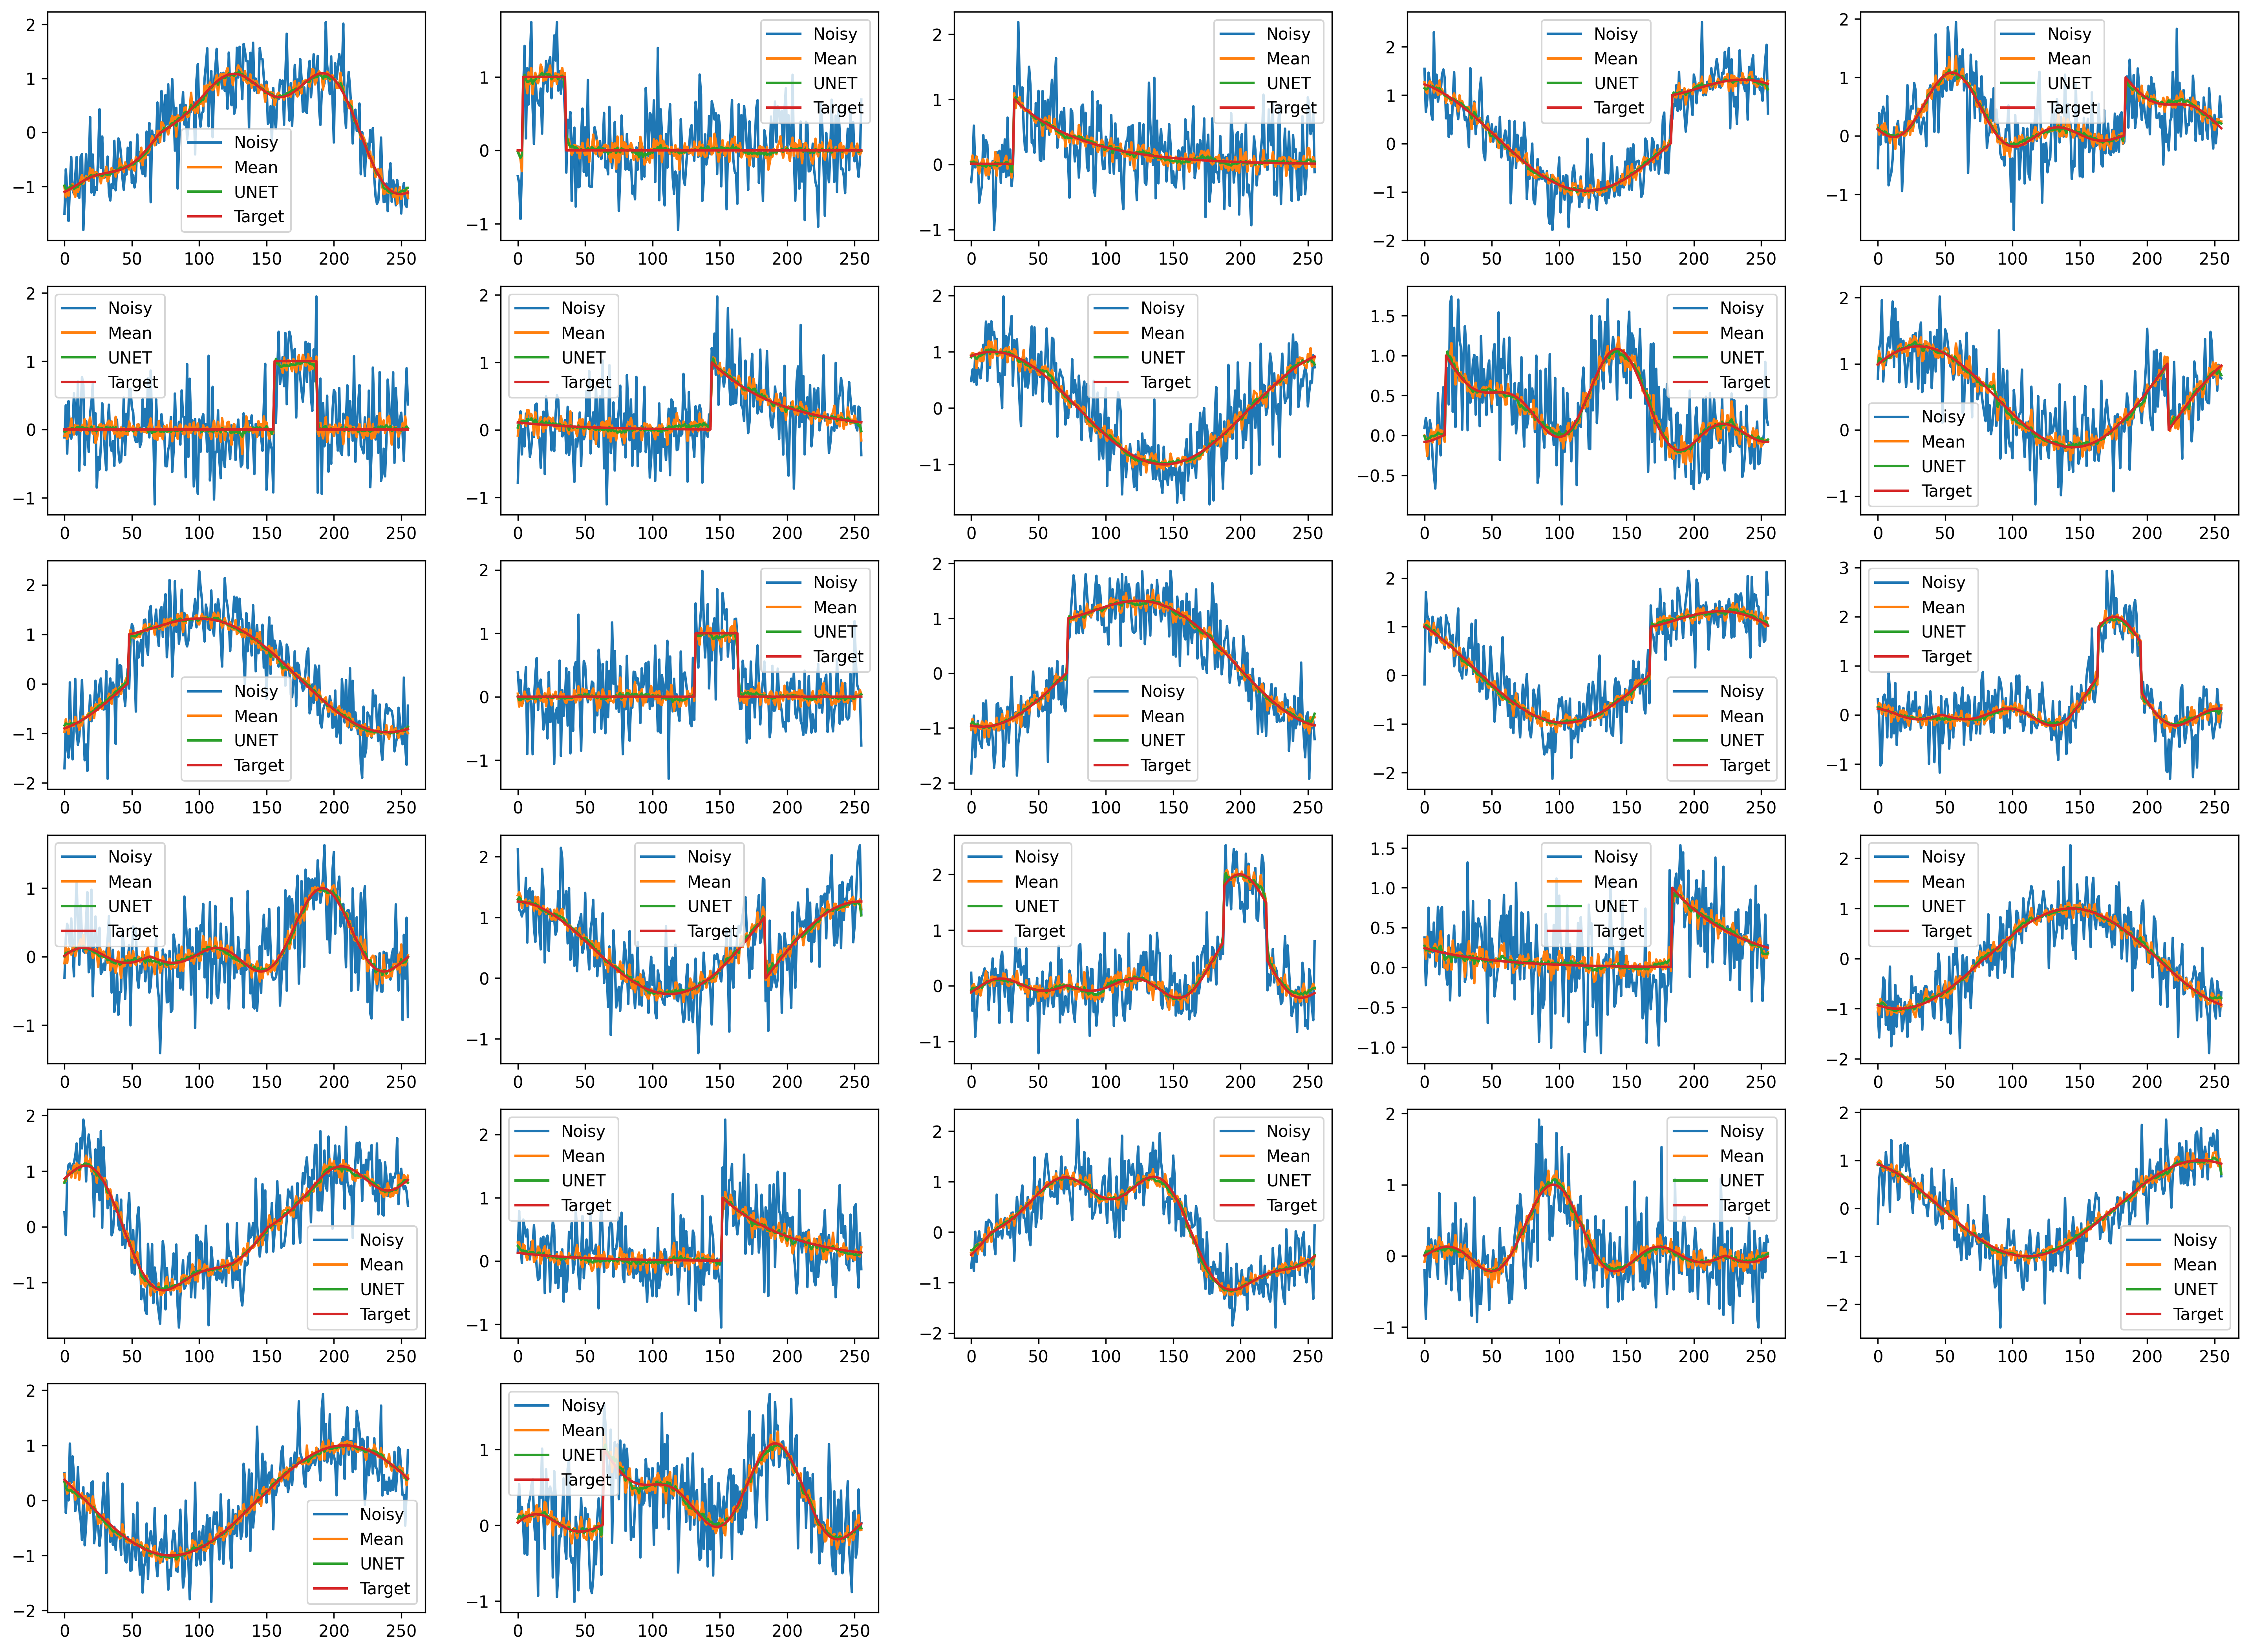

In [ ]:
model.load_weights(model_name_unet)

# ask our model to predict the smooth shape on the Test data set
Ypred = model.predict(X_test2_scaled_avg)
# the simple average of all the 20 signals for each data point, used for comparison purposes between the U-net and brute force averaging
Xmean = X_test2.mean(axis = -1)

# Need to unscale the predicted ouput on the test data set since the model will ouput scaled data
if norm_type == 1:
  Ypred_unscaled = (Ypred)*(Y_train2_std) + (Y_train2_mean)

print("Unet MSE:")
print(((Ypred_unscaled - Y_test2[:,:,np.newaxis])**2).mean())
print("Mean MSE:")
print(((Xmean - Y_test2)**2).mean())

#Showing results
plt.figure(figsize = (24,18), dpi = 300)
for (ii) in range(27):
    plt.subplot(6,5,ii+1)
    plt.plot(X_test2[ii,:,0], label = "Noisy")
    plt.plot(Xmean[ii], label = "Mean")
    plt.plot(Ypred_unscaled[ii], label = "UNET")
    plt.plot(Y_test2[ii], label = "Target")
    plt.legend()
plt.show()

##  Team members participtaion
(include the description of what each team member did and the consensus score for each team member)

- **Patrick Pickard** Designed the U-net model, callbacks, helped with data scaling and input averaging, trained U-net model, and tested as well. (**score 3**)
- **Joshua Posyluzny** Loaded, explored, augmented, scaled, and previewed all of the input data required for the U-net model. (**score 3**)
- **Davis Allan** Loaded, explored, previewed, augmented, and scaled all of the input data required for the autoencoder. (**score 3**)
- **Santiago Flores** Designed the model, cost funciton, optimizer, learning rate, and callbacks required for the autoencoder. (**score 3**)
- **Jordan Joorisity** Trained, tested, and adjusted model parameters for the autoencoder model. (**score 3**)